In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seven_stations import calc_seven_stations
from graph_denoising import graph_denoising, graph_measures
np.set_printoptions(precision=2)
%matplotlib inline  


def normalisation(all_data):
    # all_data[all_data == 0] = np.nan
    # all_data_one_by_r = 1/all_data
    all_data_one_by_r = all_data
    #print(all_data_one_by_r)
    minimum = np.nanmin(all_data_one_by_r)
    #print(minimum)
    maximum = np.nanmax(all_data_one_by_r)
    #print(maximum)
    normalized_zero_to_one = (all_data_one_by_r - minimum) / (maximum - minimum)
    #print(normalized_zero_to_one)
    normalized_zero_to_one = np.nan_to_num(normalized_zero_to_one, 0)
    return normalized_zero_to_one, minimum, maximum

def reverse_normalisation(all_results, minimum, maximum):
    # all_results = np.array(all_results, dtype=np.float32)
    all_data_one_by_r = all_results * (maximum - minimum) + minimum
    #print(all_data_one_by_r)
    # all_data_one_by_r[all_data_one_by_r == 0] = np.nan
    #print(all_data_one_by_r)
    # all_data = 1/all_data_one_by_r
    all_data = all_data_one_by_r
    #print(all_data)
    all_data = np.nan_to_num(all_data, 0)
    return all_data
    

In [125]:
a, mi, ma = normalisation(np.array([1.,2.,3.]))
np.nanmax(1/THE_array)

190021.68207868215

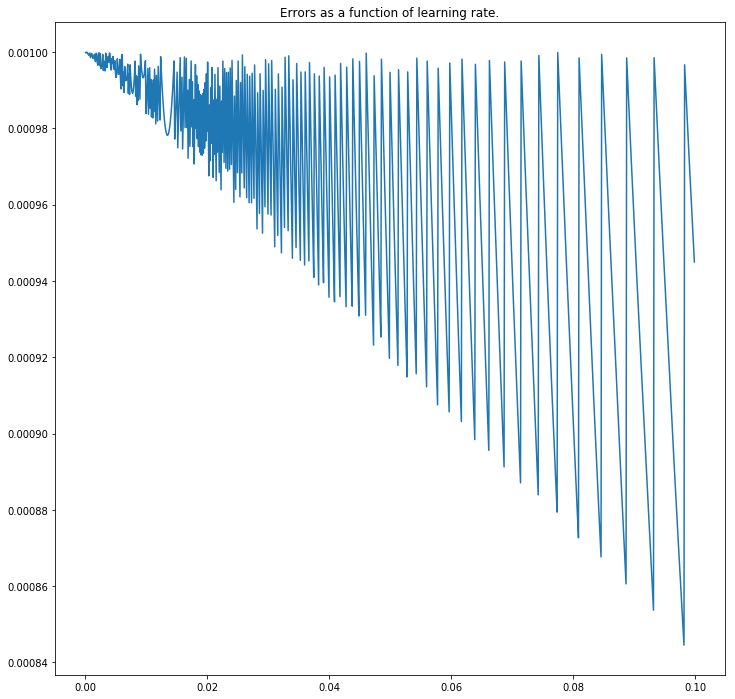

In [503]:

    
#_____________________________________________________________________________________________________________________#
#determinig the W_d.
filename_info = 'C:/MyTemp/ECMI_Data/dt/AlpArray/METRICS/2016366_local_pair_dist.txt'

distances = np.zeros((8,8))
# print(distances)
file = open(filename_info)
names = ["FR.CALF.00.HHZ",
         "FR.EILF.00.HHZ",
         "FR.ESCA.01.HHZ",
         "FR.MON.00.HHZ",
         "FR.MVIF.00.HHZ",
         "FR.PRIMA.00.HHZ",
         "FR.SAOF.00.HHZ"]
i = 0
for line in file:
    line_split = line.split(" ")
    if line_split[0] in names and line_split[1] in names:
        distances[names.index(line_split[0]), names.index(line_split[1])] = line_split[2]
        distances[names.index(line_split[1]), names.index(line_split[0])] = line_split[2]
        i = i+1
file.close()
# print(distances)

for i in range(8):
    distances[i,i] = np.nan
W_d = normalisation(distances)[0]

#_________________________________________________________________________________________________________________________# 
#read W_t
from scipy import sparse

dt_matrix_2 = sparse.load_npz('C:/MyTemp/ECMI_Data/dt/AlpArray/all-in-numpy/eight_dt.npz')

THE_array = dt_matrix_2.todense()

array, minimum, maximum = normalisation(np.array(THE_array)[:,3216])
result = np.zeros((8,8))

i = 0
j = 0
for t in range(len(array)):
    if j == i:
        j = j + 1
    #print("t= " + str(t))
    #print(array[t])
    result[i, j] = array[t]
    result[j, i] = array[t]
    # print(t)
    #print("i = " + str(i))
    #print("j = " + str(j))
    if j < 7:
        j = j + 1
    else:
        j = i + 1
        i = i + 1
W_t = result

#____________________________________________________________________________________________________________________#

estimates = graph_measures(W_d) #estimates
epsilon = 0.001 # This should be quite small

learning_rates = [0.0001*i for i in range(1,1000)]
results = [graph_denoising(W_t, estimates, epsilon, learning_rate=i, max_iterations=100000)for i in learning_rates] # ready to run when we get the matrices.
results_W = np.array([results[i][0] for i in range(0,999)])
results_t = np.array([results[i][1] for i in range(0,999)])
results_E = np.array([results[i][2] for i in range(0,999)])

width = 12
height = 12
plt.figure(figsize=(width, height))
plt.plot(learning_rates, results_E)
plt.title("Errors as a function of learning rate.")
plt.show()


In [504]:
results_E

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [505]:
learning_rate = learning_rates[np.argmin(results_E)]
learning_rate

0.09820000000000001

In [506]:
# THE_array = np.array(calc_seven_stations("C:/MyTemp/"))


In [572]:
def do_a_timeseries(dt_data, estimates, epsilon, learning_rate, max_iterations):
    W_t_arrays = np.array([make_Wt(dt_data[:,i]) for i in range(np.shape(dt_data[0,:])[1])])
    ret = [graph_denoising(W_t, estimates, epsilon, learning_rate, max_iterations) for W_t in W_t_arrays] # ready to run when we get the matrices.
    return np.array(ret)
normalized_array, minimum, maximum = normalisation(THE_array)
W_t_arrays = np.array([make_Wt(normalized_array[:,i]) for i in range(np.shape(normalized_array[0,:])[1])])
timeseries = do_a_timeseries(normalized_array, estimates, 0.001, learning_rate, 1000000)

In [573]:
asdd = np.array(list(timeseries[:,0]), dtype=np.float32)
asd = reverse_normalisation(asdd, minimum, maximum)
print(np.nanmin(THE_array))
print(np.nanmax(THE_array))
print(np.min(normalized_array))
print(np.max(normalized_array))
print(np.min(asdd))
print(np.max(asdd))
print(np.min(asd))
np.max(asd)

-3.333021402359009
3.333331823348999
0.0
1.0
0.0
1.0
-3.3330214


3.3333318

In [574]:
reversed_W_ts = reverse_normalisation(W_t_arrays, minimum, maximum)
np.max(asd - reversed_W_ts)
np.shape(timeseries[:,0])

(8640,)

In [575]:
def figure_out_the_size(integer):
    ret = 1
    summa = 1
    t = 2
    while integer != summa  and t != 100:
        # print(summa)
        summa = summa + t
        t = t + 1
    ret = t
    return ret
figure_out_the_size(21)

    

7

In [576]:
def make_Wt(array):
    size = figure_out_the_size(len(array))
    result = np.zeros((size,size))
    #result[0, 1:7] = array[0:6]
    #result[1, 0:1] = array[6]
    #result[1, 2:7] = array[7:11]
    #result[2, 0:2] = array[11:13]
    #result[2, 3:7] = array[13:16]
    i = 0
    j = 0
    for t in range(len(array)):
        if j == i:
            j = j + 1
        #print("t= " + str(t))
        #print(array[t])
        # print(i)
        # print(j)
        # print(result[i, j])
        # print(array[t])
        result[i, j] = array[t]
        result[j, i] = array[t]
        # print(t)
        #print("i = " + str(i))
        #print("j = " + str(j))
        if j < size-1:
            j = j + 1
        else:
            j = i + 1
            i = i + 1
    return result

make_Wt(array)


array([[0.00e+00, 6.55e-01, 4.24e-01, 1.51e-01, 3.43e-01, 3.36e-01,
        1.19e-01, 2.59e-02],
       [6.55e-01, 0.00e+00, 4.24e-01, 4.69e-01, 1.00e+00, 4.61e-01,
        1.19e-01, 6.03e-01],
       [4.24e-01, 4.24e-01, 0.00e+00, 4.24e-01, 4.24e-01, 4.24e-01,
        4.24e-01, 4.24e-01],
       [1.51e-01, 4.69e-01, 4.24e-01, 0.00e+00, 2.35e-04, 5.00e-02,
        0.00e+00, 3.83e-01],
       [3.43e-01, 1.00e+00, 4.24e-01, 2.35e-04, 0.00e+00, 4.27e-01,
        6.20e-01, 7.26e-01],
       [3.36e-01, 4.61e-01, 4.24e-01, 5.00e-02, 4.27e-01, 0.00e+00,
        4.25e-01, 3.04e-01],
       [1.19e-01, 1.19e-01, 4.24e-01, 0.00e+00, 6.20e-01, 4.25e-01,
        0.00e+00, 2.93e-01],
       [2.59e-02, 6.03e-01, 4.24e-01, 3.83e-01, 7.26e-01, 3.04e-01,
        2.93e-01, 0.00e+00]])

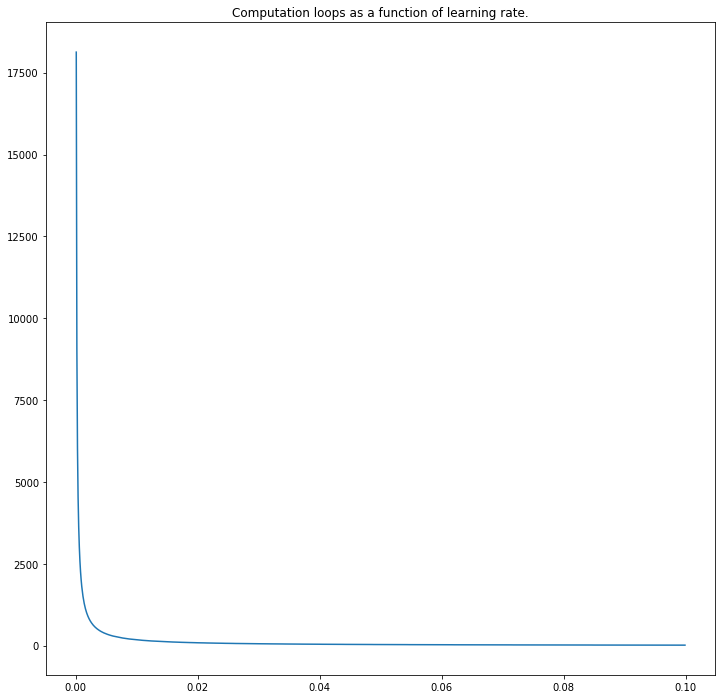

In [577]:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.plot(learning_rates, results_t)
plt.title("Computation loops as a function of learning rate.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()


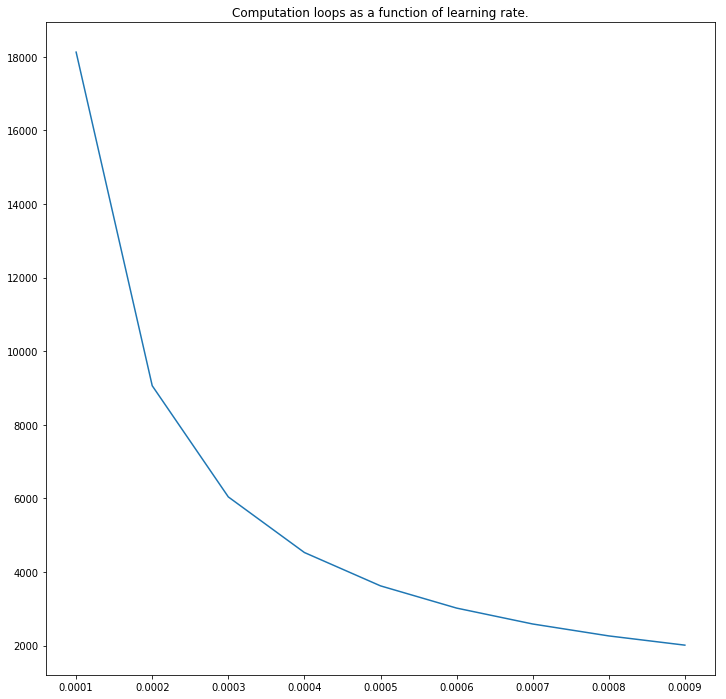

In [578]:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.plot(learning_rates[0:9], results_t[0:9])
plt.title("Computation loops as a function of learning rate.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()


In [579]:
results_W[np.argmin(results_E)] #Denoised

array([[0.  , 0.82, 0.52, 0.57, 0.45, 0.53, 0.7 , 0.  ],
       [0.82, 0.  , 0.28, 0.64, 0.87, 0.42, 0.46, 0.  ],
       [0.52, 0.28, 0.  , 0.53, 0.22, 0.31, 0.7 , 0.  ],
       [0.57, 0.64, 0.53, 0.  , 0.12, 0.26, 0.6 , 0.  ],
       [0.45, 0.87, 0.22, 0.12, 0.  , 0.33, 0.91, 0.  ],
       [0.53, 0.42, 0.31, 0.26, 0.33, 0.  , 0.8 , 0.  ],
       [0.7 , 0.46, 0.7 , 0.6 , 0.91, 0.8 , 0.  , 0.03],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  ]])

In [580]:
W_t #Noisy one

array([[0.00e+00, 6.55e-01, 4.24e-01, 1.51e-01, 3.43e-01, 3.36e-01,
        1.19e-01, 2.59e-02],
       [6.55e-01, 0.00e+00, 4.24e-01, 4.69e-01, 1.00e+00, 4.61e-01,
        1.19e-01, 6.03e-01],
       [4.24e-01, 4.24e-01, 0.00e+00, 4.24e-01, 4.24e-01, 4.24e-01,
        4.24e-01, 4.24e-01],
       [1.51e-01, 4.69e-01, 4.24e-01, 0.00e+00, 2.35e-04, 5.00e-02,
        0.00e+00, 3.83e-01],
       [3.43e-01, 1.00e+00, 4.24e-01, 2.35e-04, 0.00e+00, 4.27e-01,
        6.20e-01, 7.26e-01],
       [3.36e-01, 4.61e-01, 4.24e-01, 5.00e-02, 4.27e-01, 0.00e+00,
        4.25e-01, 3.04e-01],
       [1.19e-01, 1.19e-01, 4.24e-01, 0.00e+00, 6.20e-01, 4.25e-01,
        0.00e+00, 2.93e-01],
       [2.59e-02, 6.03e-01, 4.24e-01, 3.83e-01, 7.26e-01, 3.04e-01,
        2.93e-01, 0.00e+00]])

In [581]:
np.argmin(results_E)

981

In [582]:
the_smallest_error_so_far = results_E[np.argmin(results_E)]

In [583]:
if the_smallest_error_so_far >= np.min(results_E):
    the_best_learning_rate_so_far = learning_rates[np.argmin(results_E)]
    the_smallest_error_so_far = np.min(results_E)

In [584]:
the_smallest_error_so_far

0.0008445147320524148

In [585]:
the_best_learning_rate_so_far

0.09820000000000001

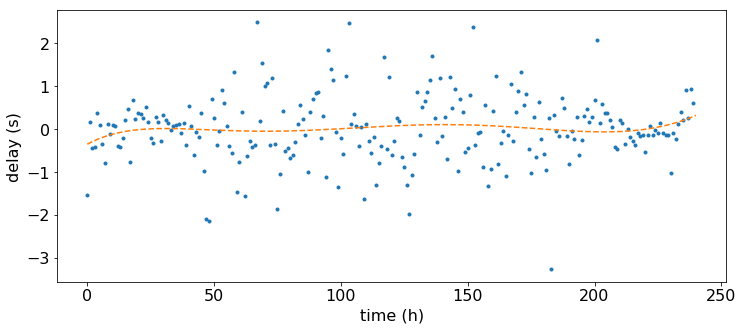

In [586]:

z = np.polyfit(range(240), reversed_W_ts[0:240,1,0], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)
width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(asd[0:240:,1,0])), reversed_W_ts[0:240,1,0], ".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Noisy time delay data.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()


In [587]:
np.shape(W_t_arrays)

(8640, 8, 8)

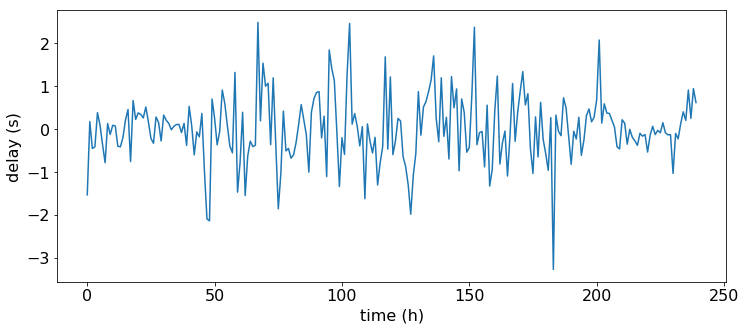

In [588]:
z = np.polyfit(range(240), reversed_W_ts[0:240,1,0], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)
width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(asd[0:240:,1,0])), reversed_W_ts[0:240,1,0])#, ".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Noisy time delay data.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()


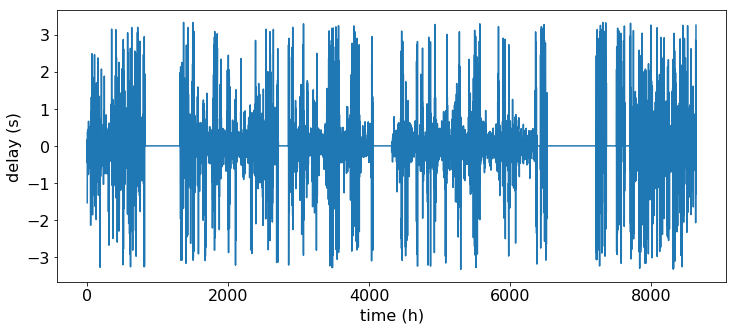

In [589]:
z = np.polyfit(range(240), reversed_W_ts[0:240,1,0], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)
width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(asd[:,1,0])), reversed_W_ts[:,1,0])#, ".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Noisy time delay data.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()

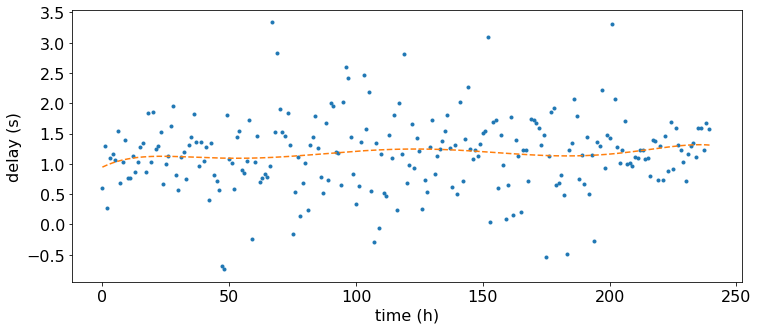

In [590]:
z = np.polyfit(range(240), asd[0:240,1,0], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)


width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(asd[0:240,1,0])), asd[0:240,1,0], ".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Denoised time delay data.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()


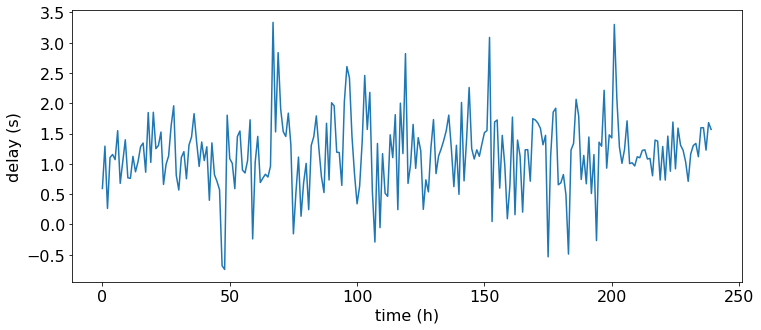

In [591]:
z = np.polyfit(range(240), asd[0:240,1,0], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)


width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(asd[0:240,1,0])), asd[0:240,1,0])#, ".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Denoised time delay data.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()

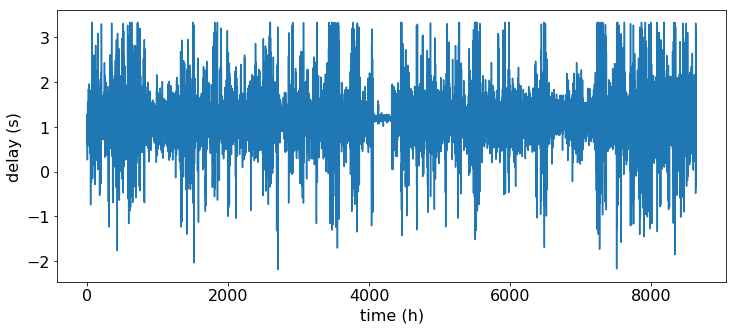

In [592]:
z = np.polyfit(range(240), asd[0:240,1,0], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)


width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(asd[:,1,0])), asd[:,1,0])#, ".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Denoised time delay data.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()

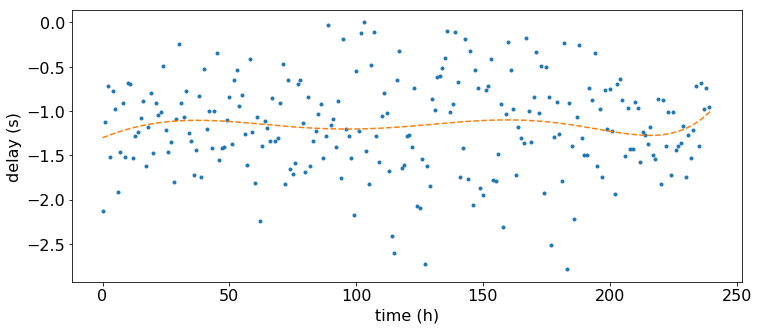

In [593]:
noise = reversed_W_ts[:,1,0] - asd[:,1,0]

z = np.polyfit(range(240), noise[0:240], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)
width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(noise[0:240])), noise[0:240], ".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Computation loops as a function of learning rate.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()


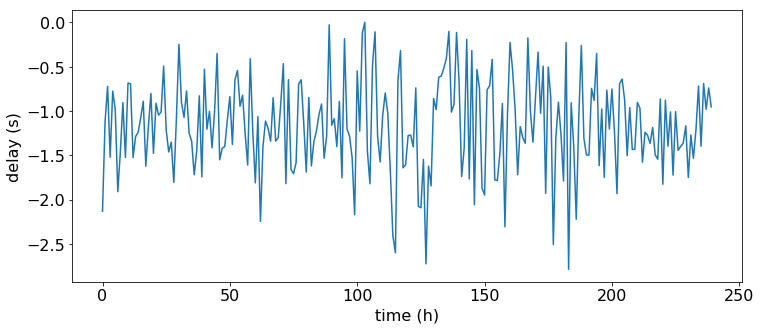

In [594]:
noise = reversed_W_ts[:,1,0] - asd[:,1,0]

z = np.polyfit(range(240), noise[0:240], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)
width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(noise[0:240])), noise[0:240])#,".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Computation loops as a function of learning rate.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()

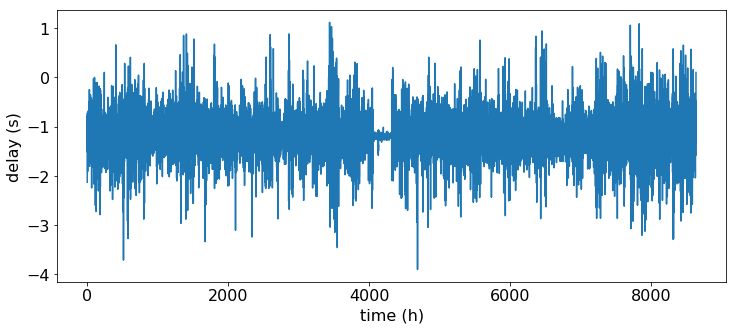

In [595]:
noise = reversed_W_ts[:,1,0] - asd[:,1,0]

z = np.polyfit(range(240), noise[0:240], 6)
p = np.poly1d(z)
xp = np.linspace(0, 240, 240)
width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(noise)), noise)#,".", xp, p(xp), "--")
plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('delay (s)', fontsize=16)
# plt.title("Computation loops as a function of learning rate.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()

In [596]:
print(xp)

[  0.     1.     2.01   3.01   4.02   5.02   6.03   7.03   8.03   9.04
  10.04  11.05  12.05  13.05  14.06  15.06  16.07  17.07  18.08  19.08
  20.08  21.09  22.09  23.1   24.1   25.1   26.11  27.11  28.12  29.12
  30.13  31.13  32.13  33.14  34.14  35.15  36.15  37.15  38.16  39.16
  40.17  41.17  42.18  43.18  44.18  45.19  46.19  47.2   48.2   49.21
  50.21  51.21  52.22  53.22  54.23  55.23  56.23  57.24  58.24  59.25
  60.25  61.26  62.26  63.26  64.27  65.27  66.28  67.28  68.28  69.29
  70.29  71.3   72.3   73.31  74.31  75.31  76.32  77.32  78.33  79.33
  80.33  81.34  82.34  83.35  84.35  85.36  86.36  87.36  88.37  89.37
  90.38  91.38  92.38  93.39  94.39  95.4   96.4   97.41  98.41  99.41
 100.42 101.42 102.43 103.43 104.44 105.44 106.44 107.45 108.45 109.46
 110.46 111.46 112.47 113.47 114.48 115.48 116.49 117.49 118.49 119.5
 120.5  121.51 122.51 123.51 124.52 125.52 126.53 127.53 128.54 129.54
 130.54 131.55 132.55 133.56 134.56 135.56 136.57 137.57 138.58 139.58
 140.59

In [597]:
range(len(asd[:,1,0]))

range(0, 8640)

In [598]:
make_Wt(np.array(list(THE_array[:,4]), dtype=np.float32))

array([[ 0.  ,  0.38,  0.  ,  0.  , -1.03, -1.49,  0.52,  0.14],
       [ 0.38,  0.  ,  0.  ,  0.  ,  1.11, -0.73,  1.11, -0.2 ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [-1.03,  1.11,  0.  ,  0.  ,  0.  , -2.12, -0.31,  0.35],
       [-1.49, -0.73,  0.  ,  0.  , -2.12,  0.  , -2.16, -0.59],
       [ 0.52,  1.11,  0.  ,  0.  , -0.31, -2.16,  0.  , -1.21],
       [ 0.14, -0.2 ,  0.  ,  0.  ,  0.35, -0.59, -1.21,  0.  ]])

In [599]:
np.shape(list(normalized_array[:,0]))

(28, 1, 1)

In [600]:
print(minimum)

-3.333021402359009


In [601]:
print(maximum)

3.333331823348999


In [602]:
normalized_array, minimum, maximum = normalisation(THE_array)

In [603]:
minimum

-3.333021402359009

In [604]:
maximum

3.333331823348999

KeyboardInterrupt: 

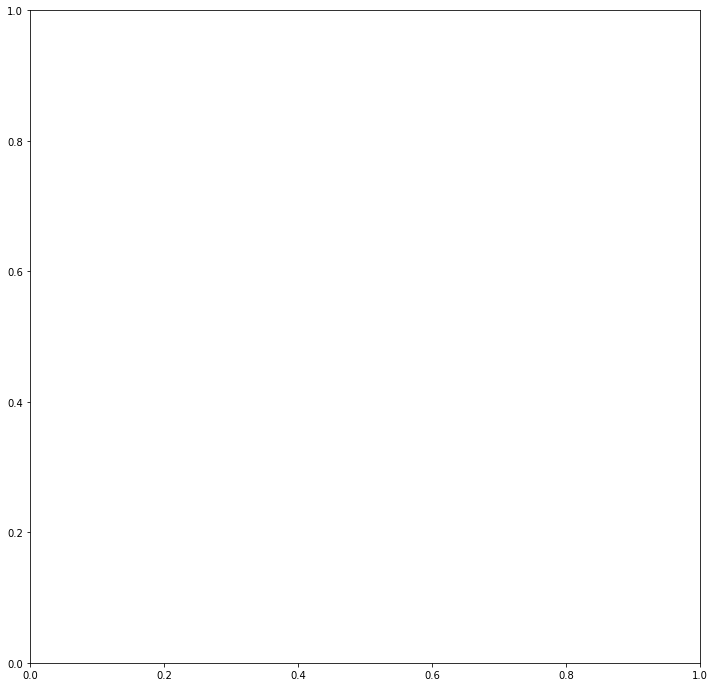

In [605]:
width = 12
height = 12
plt.figure(figsize=(width, height))
n, bins, patches = plt.hist(normalized_array.flatten(), 50, density=True, facecolor='green')
plt.show()

In [606]:
def make_connections_matrix(size):
    [(i, j) for j in range(size) for i in range(size)]
    def construct_the_line(index, size):
        ret = np.zeros(size)
        
    for i in range(size):
        number_of_connections = figure_out_the_size(size)
        construct_the_line(i, size)

In [607]:
figure_out_the_size(21)

7

In [624]:
def connections(number):
    retval = 0
    number = number - 1
    while number >= 0:
        retval = number + retval
        number = number - 1
    return retval
def make_connections_matrix(nodes):
    shape = (connections(nodes), nodes)
    #shape = (21, 7)
    t = shape[1] - 1
    result = np.zeros(shape)
    loop = 1
    line = 0
    for i in range(shape[0]):
        # print(i)
        for j in range(t):
            result[line, j + loop] = -1
            line = line+1

        t = t - 1
        loop = loop + 1
    #print(result)
    row = 0
    counter = 0
    where_to_count = shape[1] - 1
    for line in range(shape[0]):
        result[line, row] = 1
        counter = counter + 1 
        if counter >= where_to_count:
            counter = 0
            row = row + 1
            where_to_count = where_to_count - 1
    return result    

In [625]:
connections_matrix = make_connections_matrix(8)

In [626]:
def tihonov_matrix(alfa, size):
    return(alfa * np.identity(size))

tih_mat = tihonov_matrix(1e-3,8)

In [627]:
timeseries_matrices = np.array(list(timeseries[:,0]), dtype=np.float32)


In [628]:
def make_timeseries_vector(matrix):
    ret = []
    #print(matrix)
    for i in range(np.shape(matrix)[0]):
        for j in range(np.shape(matrix)[1]):
            if i < j:
                ret.append(matrix[i,j])
    return np.array(ret)

In [629]:
test = timeseries_matrices[0]
timeseries_vectors = np.array([make_timeseries_vector(timeseries_matrices[i]) for i in range(len(timeseries_matrices))])
test2[1]

array([0.55, 0.45, 0.37, 0.4 , 0.36, 0.85, 0.39, 0.41, 0.49, 0.39, 0.62,
       0.17, 0.08, 0.16, 0.46, 0.22, 0.18, 0.55, 0.21, 0.74, 0.53],
      dtype=float32)

In [630]:
the_results = np.array([
    np.dot(
        np.linalg.inv(
            np.dot(
                connections_matrix.T, 
                connections_matrix) + np.dot(
                tih_mat.T, 
                tih_mat
                )
            ),
        np.dot(
            connections_matrix.T,
            timeseries_vectors[i].T
            )
        )
    for i in range(len(timeseries_vectors))
    ]
)

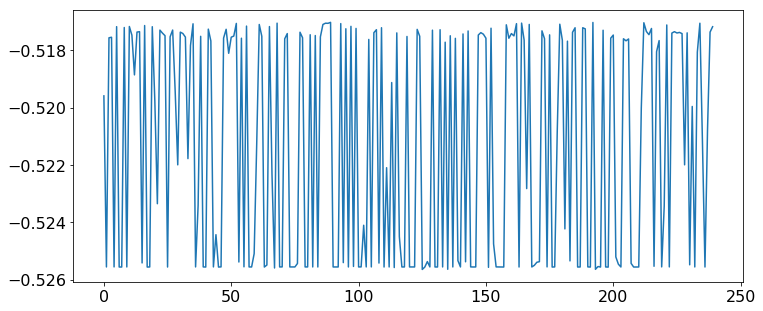

In [631]:
# noise = reversed_W_ts[:,1,0] - asd[:,1,0]
width = 12
height = 5
plt.figure(figsize=(width, height))
plt.plot(range(len(the_results[0:240,3])), the_results[0:240,6])#,".", xp, p(xp), "--")
#plt.xlabel('time (h)', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.ylabel('delay (s)', fontsize=16)
# plt.title("Computation loops as a function of learning rate.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()

In [632]:
the_results[0,0]

0.4488968884688802

In [633]:
the_results[0,1]

0.28731840138789266

In [634]:
the_results[0,2]

0.046047998301219195

In [635]:
the_results[0,3]

-0.02784388535656035

AttributeError: Unknown property sharex

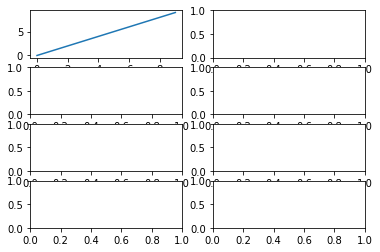

<Figure size 864x864 with 0 Axes>

In [636]:
import matplotlib.pyplot as plt

x = range(10)
y = range(10)

fig, ax = plt.subplots(nrows=4, ncols=2)
width = 12
height = 12
plt.figure(figsize=(width, height))

something = False
for row in ax:
    for col in row:
        if something:
            col.plot(x, y,sharex=ax[0])
        else:
            col.plot(x,y)
            something = True

plt.show()

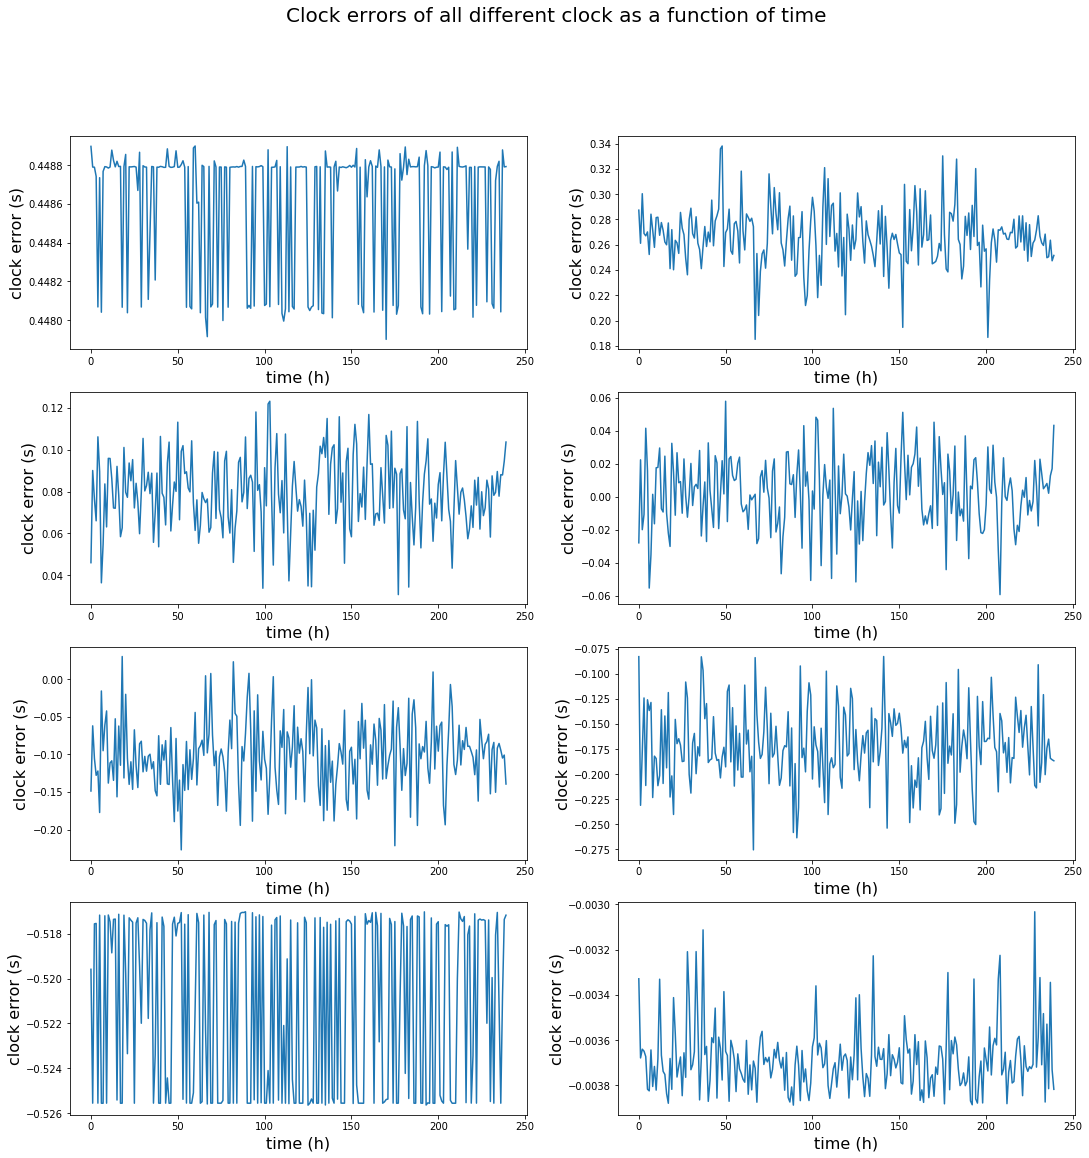

In [640]:
fig = plt.figure(figsize=(18, 18))
plt.suptitle("Clock errors of all different clock as a function of time", fontsize=20)
#plt.yticks(fontsize=16)
#plt.xticks(fontsize=16)
ax1 = fig.add_subplot(4, 2, 1,aspect='auto')
ax2 = fig.add_subplot(4, 2, 2, aspect='auto')
ax3 = fig.add_subplot(4, 2, 3, aspect='auto')
ax4 = fig.add_subplot(4, 2, 4, aspect='auto')
ax5 = fig.add_subplot(4, 2, 5, aspect='auto')
ax6 = fig.add_subplot(4, 2, 6, aspect='auto')
ax7 = fig.add_subplot(4, 2, 7, aspect='auto')
ax8 = fig.add_subplot(4, 2, 8, aspect='auto')


t = np.linspace(0, 1, 1000)

#ax = plt.gca()

ax1.plot(range(len(the_results[0:240,3])), the_results[0:240,0])
ax1.set_xlabel("time (h)", fontsize=16)
ax1.set_ylabel("clock error (s)", fontsize=16)
#ax1.tick_params()
#ax.xlabel('time (h)', fontsize=16)
#plt.yticks(fontsize=16)
#plt.xticks(fontsize=16)
#ax.ylabel('delay (s)', fontsize=16)

ax2.plot(range(len(the_results[0:240,3])), the_results[0:240,1])
ax2.set_xlabel("time (h)", fontsize=16)
ax2.set_ylabel("clock error (s)", fontsize=16)

ax3.plot(range(len(the_results[0:240,3])), the_results[0:240,2])
ax3.set_xlabel("time (h)", fontsize=16)
ax3.set_ylabel("clock error (s)", fontsize=16)

ax4.plot(range(len(the_results[0:240,3])), the_results[0:240,3])
ax4.set_xlabel("time (h)", fontsize=16)
ax4.set_ylabel("clock error (s)", fontsize=16)

ax5.plot(range(len(the_results[0:240,3])), the_results[0:240,4])
ax5.set_xlabel("time (h)", fontsize=16)
ax5.set_ylabel("clock error (s)", fontsize=16)

ax6.plot(range(len(the_results[0:240,3])), the_results[0:240,5])
ax6.set_xlabel("time (h)", fontsize=16)
ax6.set_ylabel("clock error (s)", fontsize=16)

ax7.plot(range(len(the_results[0:240,3])), the_results[0:240,6])
ax7.set_xlabel("time (h)", fontsize=16)
ax7.set_ylabel("clock error (s)", fontsize=16)

ax8.plot(range(len(the_results[0:240,3])), the_results[0:240,7])
ax8.set_xlabel("time (h)", fontsize=16)
ax8.set_ylabel("clock error (s)", fontsize=16)


plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import plotly.plotly as py

# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api


fig = plt.figure(figsize=(16, 10))
x = np.linspace(np.pi, 2*np.pi, 1000)

ax1 = fig.add_subplot(221)
y = np.sin(x)
ax1.plot(x,y)
ax1.set_title('Sine Curve')


ax2 = fig.add_subplot(222)
y = np.cos(x)
ax2.plot(x,y)
ax2.set_title('Cosine Curve')


ax3 = fig.add_subplot(223)
y = np.sin(x)
ax3.plot(x,y)
ax3.set_title('Tangent Curve')


ax4 = fig.add_subplot(224)
y = np.log(x)
ax4.plot(x,y)
ax4.set_title('Logarithmic Curve')

fig.tight_layout()
